# Linear Regression

Kita akan menggunakan dataset yang sama dengan yang digunakan pada Regresi Linear dengan sklearn. Kali ini kita ambil data dari sumber asalnya, yaitu di sini : https://www4.stat.ncsu.edu/~boos/var.select/diabetes.html

Data yang kita gunakan adalah data yang sudah dinormalisasi, sama seperti data sample scikit-learn yang kita gunakan sebelumnya.

In [1]:
# Google colab only
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=fbb7717fc1ac943d8fd13189cc248d17d3c13e502be2e12083515f335ef95164
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [2]:
import pyspark

In [3]:
# Google colab only
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('MlLib - Machine Learning').getOrCreate()

## Download dataset

In [4]:
!wget 'https://www4.stat.ncsu.edu/~boos/var.select/diabetes.rwrite1.txt'

--2024-02-05 01:17:10--  https://www4.stat.ncsu.edu/~boos/var.select/diabetes.rwrite1.txt
Resolving www4.stat.ncsu.edu (www4.stat.ncsu.edu)... 152.1.62.34
Connecting to www4.stat.ncsu.edu (www4.stat.ncsu.edu)|152.1.62.34|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 88471 (86K) [text/plain]
Saving to: ‘diabetes.rwrite1.txt’

diabetes.rwrite1.tx 100%[===================>]  86.40K  --.-KB/s    in 0.07s   

2024-02-05 01:17:10 (1.13 MB/s) - ‘diabetes.rwrite1.txt’ saved [88471/88471]



## Load Dataset into Dataframe

In [5]:
df = spark.read.csv(path='diabetes.rwrite1.txt', sep=' ', header = True, inferSchema=True)

In [6]:
df.printSchema()

root
 |-- age: double (nullable = true)
 |-- sex: double (nullable = true)
 |-- bmi: double (nullable = true)
 |-- map: double (nullable = true)
 |-- tc: double (nullable = true)
 |-- ldl: double (nullable = true)
 |-- hdl: double (nullable = true)
 |-- tch: double (nullable = true)
 |-- ltg: double (nullable = true)
 |-- glu: double (nullable = true)
 |-- y: integer (nullable = true)



In [7]:
df.show(5)

+--------------------+------------------+-------------------+--------------------+--------------------+-------------------+-------------------+--------------------+-------------------+-------------------+---+
|                 age|               sex|                bmi|                 map|                  tc|                ldl|                hdl|                 tch|                ltg|                glu|  y|
+--------------------+------------------+-------------------+--------------------+--------------------+-------------------+-------------------+--------------------+-------------------+-------------------+---+
|  0.0380759064334241|0.0506801187398187| 0.0616962065186885|  0.0218723549949558| -0.0442234984244464|-0.0348207628376986|-0.0434008456520269|-0.00259226199818282| 0.0199084208763183|-0.0176461251598052|151|
|-0.00188201652779104|-0.044641636506989|-0.0514740612388061| -0.0263278347173518|-0.00844872411121698| -0.019163339748222| 0.0744115640787594| -0.0394933828740919|

In [8]:
df.describe().show()

+-------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+
|summary|                 age|                 sex|                 bmi|                 map|                  tc|                 ldl|                 hdl|                 tch|                 ltg|                 glu|                 y|
+-------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+
|  count|                 442|                 442|                 442|                 442|                 442|                 442|                 442|                 442|                 442|                 442|               442|
|   mean|-3.64182037970226...|1.308342574551

In [9]:
training = df.select(["age","sex","bmi","map","tc","ldl","hdl","tch","ltg","glu"])
training.show(5)

+--------------------+------------------+-------------------+--------------------+--------------------+-------------------+-------------------+--------------------+-------------------+-------------------+
|                 age|               sex|                bmi|                 map|                  tc|                ldl|                hdl|                 tch|                ltg|                glu|
+--------------------+------------------+-------------------+--------------------+--------------------+-------------------+-------------------+--------------------+-------------------+-------------------+
|  0.0380759064334241|0.0506801187398187| 0.0616962065186885|  0.0218723549949558| -0.0442234984244464|-0.0348207628376986|-0.0434008456520269|-0.00259226199818282| 0.0199084208763183|-0.0176461251598052|
|-0.00188201652779104|-0.044641636506989|-0.0514740612388061| -0.0263278347173518|-0.00844872411121698| -0.019163339748222| 0.0744115640787594| -0.0394933828740919|-0.0683297436244

## Split Training-testing Dataset

Split data menjadi train-test data, dengan perbandingan 80:20

In [10]:
from pyspark.sql.functions import col

features = ["age","sex","bmi","map","tc","ldl","hdl","tch","ltg","glu"]
label = 'y'

df_selected = df.select(*features, col(label).alias("label"))
(training, test) = df_selected.randomSplit([.8, .2])

Sebelum digunakan dalam proses training, kita satukan dulu kolom-kolom input menjadi satu vektor feature dengan `VectorAssembler`

In [11]:
from pyspark.ml.feature import VectorAssembler

vectorAssembler = VectorAssembler(inputCols=features, outputCol="features")
training = vectorAssembler.transform(training)
training.show(5, False)

+------------------+------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------------+--------------------+-------------------+-----+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|age               |sex               |bmi                |map                |tc                 |ldl                |hdl                |tch                 |ltg                 |glu                |label|features                                                                                                                                                                                               |
+------------------+------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------------+--------------------+---

## Linear Regreesion Model

###Training dan evaluasi

In [12]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8)

# Fit the model
lrModel = lr.fit(training)

# Print the coefficients and intercept for linear regression
print("Coefficients: %s" % str(lrModel.coefficients))
print("Intercept: %s" % str(lrModel.intercept))

# Summarize the model over the training set and print out some metrics
trainingSummary = lrModel.summary
print("numIterations: %d" % trainingSummary.totalIterations)
print("objectiveHistory: %s" % str(trainingSummary.objectiveHistory))
trainingSummary.residuals.show(5)
print("model RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("model r2: %f" % trainingSummary.r2)
print("model adjusted r2: %f" % trainingSummary.r2adj)

Coefficients: [29.82528246685948,-229.40354897898578,538.1138576287808,305.28789476303234,-69.53452528966905,-71.31181034165093,-208.56353827214141,62.510422029236075,521.0955402136278,57.55182779041414]
Intercept: 153.24931409849182
numIterations: 10
objectiveHistory: [0.4999999999999998, 0.44412597431837186, 0.27312493098457874, 0.26467695752537634, 0.2456843314638537, 0.2437130195803324, 0.24322522870071053, 0.24302637324958945, 0.24286814832155093, 0.2427862340659139, 0.2427108591349959]
+-------------------+
|          residuals|
+-------------------+
|  46.06889601384236|
| 18.409586644646197|
| 22.125552207646464|
|0.47866206737131733|
| -15.17120403425099|
+-------------------+
only showing top 5 rows

model RMSE: 54.198802
model r2: 0.522600
model adjusted r2: 0.508882


Dari hasil di atas, terlihat model kita relatif kurang baik dari sisi RMSE (masih di atas 0.5) maupun adjusted R-Squared (masih di bawah 0.75).

Akan tetapi angka-angka tersebut hanya merupakan panduan saja. Evaluasi akhir tergantung pada kebutuhan maupun ketersediaan data.

In [13]:
#prediction
test1 = vectorAssembler.transform(test)
predictions = lrModel.transform(test1)

# Select example rows to display.
print("\nModel Prediction Result :  ")
predictions.select("features","label","prediction").show(5)


Model Prediction Result :  
+--------------------+-----+------------------+
|            features|label|        prediction|
+--------------------+-----+------------------+
|[-0.1072256316073...|  200| 140.7687722319818|
|[-0.0963280162542...|  134| 71.95205664353476|
|[-0.0890629393522...|  206|161.72064031461935|
|[-0.0781653239992...|  152|106.40661072541582|
|[-0.0745327855481...|  103| 141.0961971201562|
+--------------------+-----+------------------+
only showing top 5 rows



In [14]:
from pyspark.ml.evaluation import RegressionEvaluator

# Select (prediction, true label) dan hitung error
evaluator1 = RegressionEvaluator(labelCol="label",
                                predictionCol="prediction",
                                metricName="rmse")
rmse1 = evaluator1.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse1)

evaluator2 = RegressionEvaluator(labelCol="label",
                                predictionCol="prediction",
                                metricName="r2")
r21 = evaluator2.evaluate(predictions)
print("R-Squared on test data = %g" % r21)



Root Mean Squared Error (RMSE) on test data = 51.6539
R-Squared on test data = 0.461699


##Visualisasi actual vs. predicted

Hati-hati untuk data yang sangat besar, karena perintah `collect()` akan mengumpulkan seluruh hasil operasi dataframe dari seluruh eksekutor node.

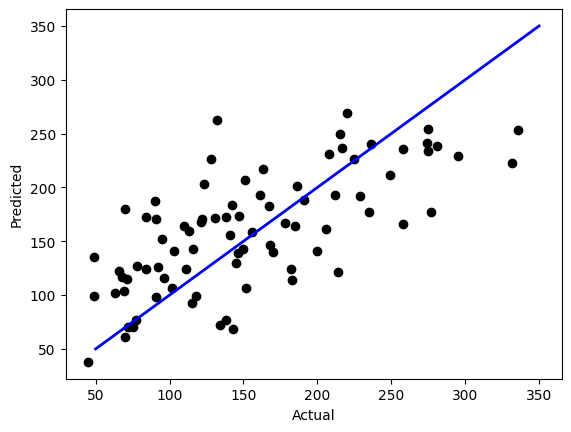

In [15]:
import matplotlib.pyplot as plt


ytest=predictions.select("label").collect()
diabetes_y_pred=predictions.select("prediction").collect()

plt.scatter(ytest, diabetes_y_pred, color="black")
plt.plot([50,350], [50,350], color="blue", linewidth=2)

plt.xlabel('Actual')
plt.ylabel('Predicted')

plt.show()

Idealnya actual vs. predicted mendekati garis biru (x=y).

Dari plot hasil prediksi kita, terlihat bahwa meskipun polanya sudah mengikuti, namun penyimpangan hasil prediksi masih relatif besar.

Pada nilai aktual kecil (sekitar <=150), hasil prediksi lebih banyak melebihi nilai aktualnya, sedangkan pada nilai aktual besar, prediksi model kebanyakan kurang dari hasil aktualnya.